# 08 Graph Exploration

This notebook explores the Neo4j graph produced by `scripts/build_graph.py`.

Goals:
1. Connect to Neo4j
2. Print graph statistics
3. Run example graph queries
4. Visualize a subgraph with NetworkX/Matplotlib
5. Inspect graph quality (missing nodes, broken chains, weak links)


In [1]:
from __future__ import annotations

import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

ROOT = Path.cwd().resolve().parent if Path.cwd().name == "notebooks" else Path.cwd().resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src.graph.builder import KnowledgeGraphBuilder
from src.graph.query import GraphQuerier

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 50)


In [4]:
# Neo4j connection (override with environment variables if needed).
NEO4J_URI = os.getenv("NEO4J_URI", "bolt://localhost:7687")
NEO4J_USER = os.getenv("NEO4J_USER", "neo4j")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD", "Password")

builder = KnowledgeGraphBuilder(uri=NEO4J_URI, user=NEO4J_USER, password=NEO4J_PASSWORD)
querier = GraphQuerier(builder.driver)

print("Connected to Neo4j:", NEO4J_URI)


Connected to Neo4j: bolt://localhost:7687


## Graph Statistics


In [5]:
stats = builder.get_stats()
stats


{'nodes_by_label': {},
 'relationships_by_type': {},
 'total_nodes': 0,
 'total_relationships': 0}

In [11]:
from neo4j import GraphDatabase

driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "Password"))

with driver.session() as session:
    # Count all nodes
    result = session.run("MATCH (n) RETURN count(n) AS total")
    print("Total nodes:", result.single()["total"])
    
    # Count by label
    result = session.run("MATCH (n) RETURN labels(n) AS label, count(n) AS cnt ORDER BY cnt DESC")
    for r in result:
        print(r["label"], r["cnt"])
    
    # Count relationships
    result = session.run("MATCH ()-[r]->() RETURN type(r) AS rel_type, count(r) AS cnt ORDER BY cnt DESC")
    for r in result:
        print(r["rel_type"], r["cnt"])

driver.close()

Total nodes: 1624
['Scholar'] 1074
['Hadith'] 500
['Concept'] 27
['Place'] 20
['Book'] 3
NARRATED_FROM 2396
MENTIONS_CONCEPT 178
AUTHORED 10
IN_BOOK 1


In [13]:
from neo4j import GraphDatabase

driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "Password"))

with driver.session() as session:
    result = session.run("MATCH (n) RETURN labels(n)[0] AS label, count(n) AS cnt ORDER BY cnt DESC")
    nodes_data = [{"label": r["label"], "count": r["cnt"]} for r in result]
    
    result = session.run("MATCH ()-[r]->() RETURN type(r) AS rel_type, count(r) AS cnt ORDER BY cnt DESC")
    rels_data = [{"type": r["rel_type"], "count": r["cnt"]} for r in result]

driver.close()

nodes_df = pd.DataFrame(nodes_data)
rels_df = pd.DataFrame(rels_data)

display(nodes_df)
display(rels_df)

,label,count
0,Scholar,1074
1,Hadith,500
2,Concept,27
3,Place,20
4,Book,3


,type,count
0,NARRATED_FROM,2396
1,MENTIONS_CONCEPT,178
2,AUTHORED,10
3,IN_BOOK,1


## Example Query 1: Show the narration chain for hadith #1


In [14]:
hadith_id = "bukhari_1"
chain = querier.get_narration_chain(hadith_id)
chain_df = pd.DataFrame(chain)
chain_df


,source,target,confidence,evidence
0,الحميدي عبد الله بن الزبير,سفيان,0.7,narration trigger before scholar pair
1,سفيان,يحيي بن سعيد الانصاري,0.7,narration trigger before scholar pair
2,عمر بن الخطاب,رسول الله صلي الله عليه,0.7,narration trigger before scholar pair
3,يحيي بن سعيد الانصاري,محمد بن ابراهيم,0.7,narration trigger before scholar pair


## Example Query 2: Who are Abu Huraira's direct narrators?


In [15]:
abu = querier.find_scholar("??? ?????")
if not abu:
    abu = querier.find_scholar("??? ?????")

if not abu:
    print("Abu Huraira not found in graph.")
else:
    connections = querier.get_scholar_connections(abu["canonical_name"])
    print("Matched scholar:", abu)
    print("Narrates from (teachers):", len(connections["teachers"]))
    print("Narrated by (students):", len(connections["students"]))
    display(pd.DataFrame({"teachers": connections["teachers"]}))
    display(pd.DataFrame({"students": connections["students"]}))


Abu Huraira not found in graph.


## Example Query 3: What concepts appear in Kitab al-Iman?


In [16]:
# This query uses Hadith.chapter because Kitab al-Iman is a chapter label.
chapter_terms = ["???? ???????", "???? ???????", "???????"]
query = (
    "MATCH (h:Hadith)-[:MENTIONS_CONCEPT]->(c:Concept) "
    "WHERE any(term IN $chapter_terms WHERE coalesce(h.chapter, '') CONTAINS term) "
    "RETURN c.term AS concept, count(*) AS mentions "
    "ORDER BY mentions DESC, concept"
)

with builder.driver.session() as session:
    rows = [dict(r) for r in session.run(query, chapter_terms=chapter_terms)]

concepts_df = pd.DataFrame(rows)
concepts_df


""


## Example Query 4: Shortest path between two scholars


In [17]:
scholar_a = querier.find_scholar("??? ???? ?? ????")
scholar_b = querier.find_scholar("????")

if not scholar_a or not scholar_b:
    print("Could not resolve both scholars. Try different names with querier.find_scholar().")
else:
    path = querier.shortest_path(scholar_a["canonical_name"], scholar_b["canonical_name"])
    print("Scholar A:", scholar_a["canonical_name"])
    print("Scholar B:", scholar_b["canonical_name"])
    print("Shortest path length:", len(path))
    path


Could not resolve both scholars. Try different names with querier.find_scholar().


## Subgraph Visualization (Neo4j -> NetworkX -> Matplotlib)


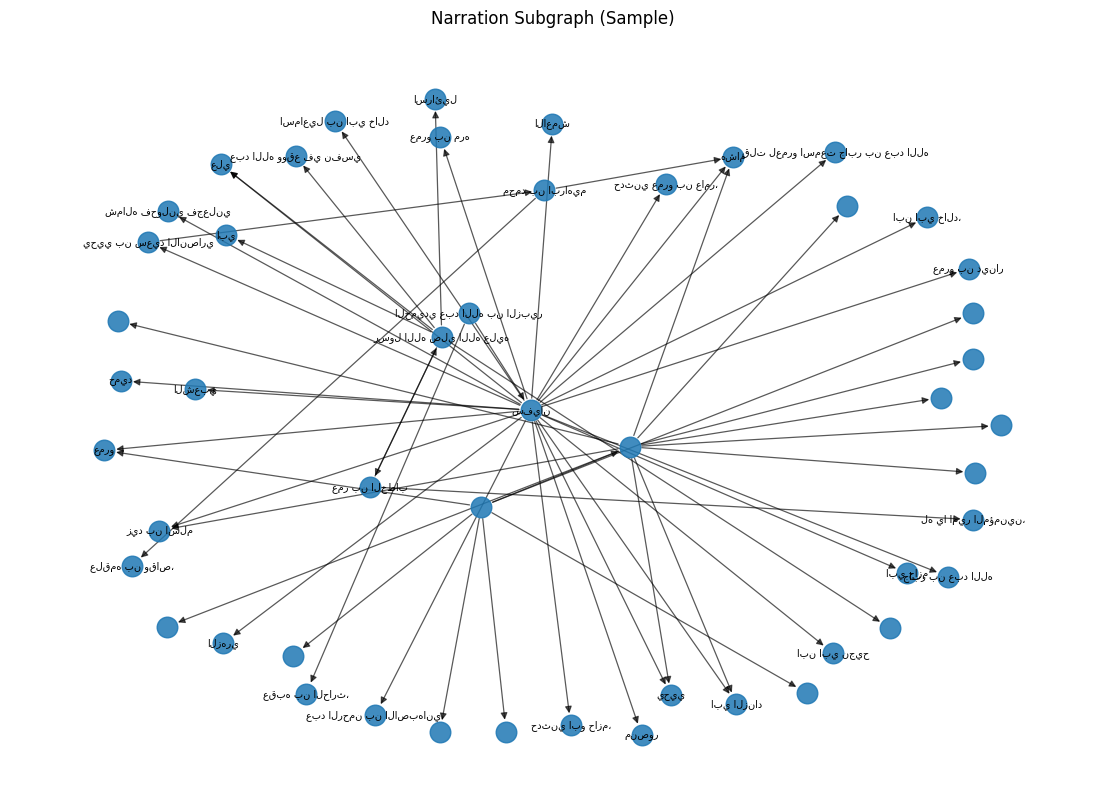

In [18]:
edge_limit = 120
cypher = (
    "MATCH (a:Scholar)-[r:NARRATED_FROM]->(b:Scholar) "
    "RETURN a.canonical_name AS source, b.canonical_name AS target, r.confidence AS confidence "
    "LIMIT $edge_limit"
)

with builder.driver.session() as session:
    edge_rows = [dict(r) for r in session.run(cypher, edge_limit=edge_limit)]

G = nx.DiGraph()
for row in edge_rows:
    G.add_edge(row["source"], row["target"], confidence=float(row.get("confidence", 0.0)))

plt.figure(figsize=(14, 10))
if G.number_of_nodes() == 0:
    print("No narration edges found to visualize.")
else:
    pos = nx.spring_layout(G, seed=42, k=1.0)
    nx.draw_networkx_nodes(G, pos, node_size=220, alpha=0.85)
    nx.draw_networkx_edges(G, pos, arrows=True, width=0.9, alpha=0.65)
    sample_labels = {n: n for n in list(G.nodes())[:35]}
    nx.draw_networkx_labels(G, pos, labels=sample_labels, font_size=7)
    plt.title("Narration Subgraph (Sample)", fontsize=12)
    plt.axis("off")
    plt.show()


## Graph Quality Diagnostics


In [19]:
quality_queries = {
    "hadith_without_book": "MATCH (h:Hadith) WHERE NOT (h)-[:IN_BOOK]->(:Book) RETURN count(h) AS count",
    "scholars_isolated": "MATCH (s:Scholar) WHERE NOT (s)-[:NARRATED_FROM]-(:Scholar) RETURN count(s) AS count",
    "low_conf_relations": "MATCH ()-[r]->() WHERE coalesce(r.confidence, 1.0) < 0.7 RETURN count(r) AS count",
    "hadith_without_concept": "MATCH (h:Hadith) WHERE NOT (h)-[:MENTIONS_CONCEPT]->(:Concept) RETURN count(h) AS count",
}

quality_rows = []
with builder.driver.session() as session:
    for name, query in quality_queries.items():
        rec = session.run(query).single()
        quality_rows.append({"metric": name, "count": int(rec["count"]) if rec else 0})

quality_df = pd.DataFrame(quality_rows).sort_values("metric")
quality_df


,metric,count
0,hadith_without_book,499
3,hadith_without_concept,369
2,low_conf_relations,178
1,scholars_isolated,244


### Discussion: Graph Quality

Use the diagnostics above to inspect quality issues:
- **Missing nodes/links**: many `hadith_without_book` or `hadith_without_concept` indicates extraction misses or metadata gaps.
- **Broken chains**: high `scholars_isolated` can indicate fragmented isnad extraction or unresolved name normalization.
- **Weak relations**: high `low_conf_relations` suggests noisy rule matches; review evidence patterns and thresholds.
- **Next fixes**: add targeted post-rules for boundary cleanup, expand gazetteer variants, and audit false-positive scholar spans in matn text.


In [ ]:
# Cleanup (run when done).
builder.close()
